In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from models.ProteinModel import ProteinModel
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [7]:
merged_df = pd.read_csv('merged_df_24_11_09_only_exact_values.csv', index_col=0)

Since we are going to further color the embeddings of proteins by their best-binding ligands, we should first know how many ligands exist per protein studied.

If proteins mostly have one ligand, then it is of no value to take the best-binding ligand, since there would only be one. 

We could think of weighting each ligand with the strength of the affinity when training the kNN classifier. E.g. if there is only one ligand for a certain protein, but this ligand binds very well, then we should rely on it more to infer a good ligand for an unseen protein (and the other way around, we should not rely on a ligand that turned out not binding well to the training protein).

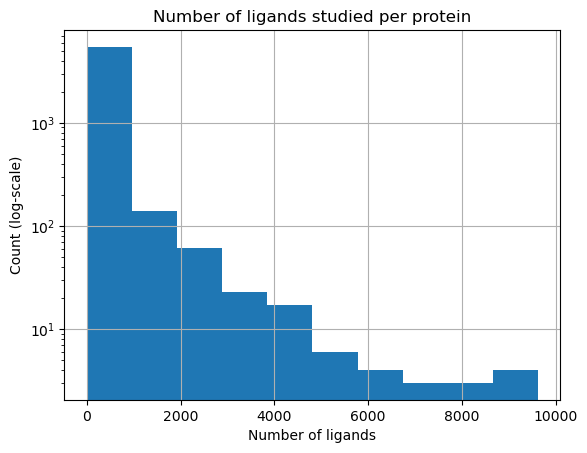

In [95]:
grouped_by_proteins = merged_df.groupby(['Target Name', 'BindingDB Target Chain Sequence', 'UniProt (SwissProt) Entry Name of Target Chain'])['Ligand SMILES'].count().reset_index()
grouped_by_proteins['Ligand SMILES'].hist(log=True)
plt.title('Number of ligands studied per protein')
plt.xlabel('Number of ligands')
plt.ylabel('Count (log-scale)');

Based on those results, we could decide on using only proteins for which more than a certain amount of ligands have been studied, e.g. 10 ligands.

In [100]:
filtered_grouped_by_proteins = grouped_by_proteins.loc[grouped_by_proteins['Ligand SMILES'] > 10]
round(filtered_grouped_by_proteins.shape[0] / grouped_by_proteins.shape[0], 3)

0.613

Determine the best-binding ligand (i.e. lowest IC50) for each protein and use it as a label for a downstream cluster analysis.

In [85]:
best_ligand_idx = merged_df.groupby(['Target Name', 'BindingDB Target Chain Sequence', 'UniProt (SwissProt) Entry Name of Target Chain'])['IC50 (nM)'].idxmin().reset_index()
best_ligand_ic50 = merged_df.loc[best_ligand_idx['IC50 (nM)'], ['Target Name', 'BindingDB Target Chain Sequence', 'UniProt (SwissProt) Entry Name of Target Chain', 'Ligand SMILES', 'IC50 (nM)']]

As seen above, even if we restrict our analysis to proteins that have been studied against more than 10 ligands, we obtain a fairly good percentage of the original data.

In [102]:
filtered_best_ligand_ic50 = best_ligand_ic50.merge(filtered_grouped_by_proteins, on=['Target Name', 'BindingDB Target Chain Sequence', 'UniProt (SwissProt) Entry Name of Target Chain'], how='inner')

Use ESM2 to find protein embeddings on a small subset of the data

In [106]:
model = ProteinModel()

In [191]:
subset_filtered_best_ligand_ic50 = filtered_best_ligand_ic50.iloc[1:300].copy()

subset_filtered_best_ligand_ic50['ESM2 Embedding'] = subset_filtered_best_ligand_ic50['BindingDB Target Chain Sequence'].apply(model.get_embeddings)

Apply dimensionality reduction to find a low-dimensional space

In [192]:
X = np.array([np.squeeze(x) for x in subset_filtered_best_ligand_ic50['ESM2 Embedding']])

# Normalize the features
X_normalized = StandardScaler().fit_transform(X)

# Apply the PCA
n = 3
pca = PCA(n_components=n)
X_transformed = pca.fit_transform(X_normalized)

# Store in the main data frame
lowd_embeddings = pd.DataFrame(X_transformed, columns=[f'PC {i}' for i in range(1,n+1)])
lowd_embeddings.set_index(small_fbl.index, inplace=True)
subset_filtered_best_ligand_ic50 = pd.concat([subset_filtered_best_ligand_ic50, lowd_embeddings], axis=1)

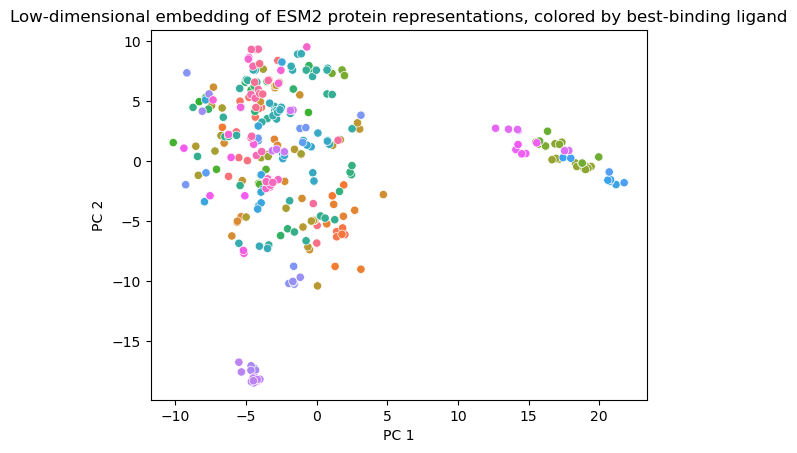

In [193]:
sns.scatterplot(data=subset_filtered_best_ligand_ic50, x='PC 1', y='PC 2', hue='Ligand SMILES_x', legend=False)
plt.title('Low-dimensional embedding of ESM2 protein representations, colored by best-binding ligand');

The first step is to assess whether clusters make sense (biologically speaking): proteins with similar properties should embed similarly onto the low-dimensional space, and a specific ligand should bind similarly to similar proteins. Do we observe such clusters?

If so, we can continue our analysis and "train" a **k-nearest neighbors** classifier based on those clusters.

In [222]:
# Create dummy variables for ligand names (labels)

ligand_to_number = {ligand: idx for idx, ligand in enumerate(set(small_fbl['Ligand SMILES_x']))}
y = [ligand_to_number[ligand] for ligand in small_fbl['Ligand SMILES_x']]

There is an issue with doing a cross-validation with the actual state of the labels, since a ligand may be present only 1 time in the dataset, so we cannot split equally among classes. (So below is the template for running the CV, but we need to engineer the ligand space, e.g. by binning before running it.)

In [ ]:
# Cross-validation

number_of_neighbors = [k for k in np.logspace(1, 2, 15, dtype=int)] # hyperparameter

precision_scores = []
recalls_scores = []

for k in number_of_neighbors:
    clf = KNeighborsClassifier(k)
    clf.fit(X_transformed, y)
    precision = cross_val_score(clf, X_transformed, y, cv=2, scoring='precision')
    precision_scores.append(precision.mean())
    recall = cross_val_score(clf, X_transformed, y, cv=2, scoring='recall')
    recall_scores.append(recall.mean())

In [ ]:
fig, ax = plt.subplots(1, figsize=(6,4))

ax.plot(number_of_neighbors, precision_scores, label="Precision")
ax.plot(number_of_neighbors, recall_scores, label="Recall")

ax.set_ylabel("Score value")
ax.set_xlabel("Number of neighbors")
ax.legend()